# Mussel pattern formation in PyOpenCL

From:
*Van de Koppel, J., Rietkerk, M., Dankers, M. & Herman, P.M.J. 2005 Scale-dependent feedback and regular spatial patterns in young mussel beds. The American Naturalist 165:E66-E77.*

A simple model suffices to show that the interaction of algal competition and density- dependent mortality can explain the formation patterns in mussels. This model describes the interaction of the concentration of algae $A$ in the lower water layer, and the biomass of mussels $M$ on the tidal flat:

$$
\begin{aligned}
\frac{\partial A}{\partial t}&= (A_{up}-A)f - \frac{c}{h}AM - V\nabla_{y} A \\
\frac{\partial M}{\partial t}&= ecAM - d_{M}\frac{k_{M}}{k_{M}+M}M + D \Delta M
\end{aligned}
$$

Here, $A_{up}$ is the concentration of algae in the upper water layer, $f$ is the exchange rate of water between the upper and lower water layer, $c$ is a consumption constant, $h$ is the depth of the lower water layer, $V$ is the advection rate of the water, $e$ is the assimilation efficientcy of the algal material into mussel tissue, $d_{M}$ is the mortality rate for isolated mussels, $k_{M}$ is the mussel density for which mortality has dropped by half, and finally $D$ is the dispersal constant for the mussels.

For more details, see the paper [here](https://pure.knaw.nl/ws/files/466748/VandeKoppel_ea_3467.pdf)

Below we implement this model in iPython.

### Loading some crucial python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import time,os
%matplotlib inline

# Widening the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Parameter definitions 
Here, the parameters that are found in the equations are given their value. For completeness, also their units and explanations are given.

In [2]:
# Algal Exchange parameters
Aup      =  1.1        # g/m3  Algal concentration in upper layer  Oosterschelde data
h        =  0.10       # m     Height of the lower layer  defined
f        =  100.0      # m3/m3/h  Phichange rate with upper layer  Guestimated

# Mussel update, growth & mortality parameters
c        =  0.1        # g/g/h Maximal consumption rate of the mussels  Riisgard 2001 
e        =  0.2        # g/g   Trophic efficiency of mussels  Lamie
dM       =  0.02       # g/g/h Density dependent mortality rate of the mussels  Calibrated
kM       =  150.0      # g/m2  Effect of density on mortality  Guestimated

# Spatial movement parameters
D        =  0.0005     # m2/h  The diffusion constant describing the movement of mussels
V        =  0.1*60*60  # m/h   Tidal advection constant(0.1 m/s * 60 sec * 60 min)

### Mussel acceleration factor 
Mussel growth occurs on vastly different timescale then water flow. Water flow occurs at a timescale of seconds, while a mussel bed develops at the timescale of months. To avoid enormously long simulation times, we accelerate mussel growth, mortality, and dispersal by multiplying the mussel differential equation with a factor $\phi$ (Phi).  

In [3]:
Phi      =  1000.0    # Speeding constant, accelerates mussel growth

### Parameters that determine how the simulation is run

In [4]:
Length_X    = 150      # Length of the physical landscape
Length_Y    = 100      # Length of the physical landscape
Grid_Width  = 768      # Size of the 2D grid in X dimension
Grid_Height = 512      # Size of the 2D grid in Y dimension
BlockSize   = 32       # Size of the workgroup with the GPU 

EndTime  =  180*24/Phi # Total simulation time
NumPlots =  180        # Number of times the figure is updated
dT       =  0.00025    # Time step

### Some pre-computations

In [5]:
dX = Length_X/Grid_Width  # Spatial step size
dY = Length_Y/Grid_Height # Spatial step size

### Colormap definitions
Creates a nice colormap from the color of wet mud (yellow-gray) to the color of dry mud with shells (whitish) to the dark color of the mussels themselves (assuming zero barnacle cover).

In [6]:
from matplotlib.colors import LinearSegmentedColormap

# Colormap definition for the Algae
AlgaeColors = [(0.84, 1.0, 1.0), (0.25, 0.8, 0.5)] 
AlgaeMap = LinearSegmentedColormap.from_list('Water', AlgaeColors, N=100)

# Colormap definition for the mussels
MusselColors = [(0.70, 0.67, 0.62), (0.97, 0.89, 0.82), (0.64, 0.64, 0.71),\
                (0.44, 0.48, 0.56), (0.20, 0.27, 0.28), (0.0 , 0.0 , 0.0)]  
MusselMap = LinearSegmentedColormap.from_list('AridVeg', MusselColors, N=100)

### Initializing the data arrays and giving them starting values

In [7]:
# %% Defining the initial values
np.random.seed(3)
A = np.zeros((Grid_Width*Grid_Height))+Aup
M = (np.random.rand(Grid_Width*Grid_Height) < 0.05) * 300.0+50.0

A_host = A.astype(np.float32)
M_host = M.astype(np.float32)

### Setting up the Graphics Card Unit (GPU) for OpenCL use

In [8]:
import pyopencl as cl

# Defining the device that is used, specific to my MacBook pro
DeviceNr = 2   # 0 = CPU; 1 = Intel; 2 = AMD 
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "0" # Set to 1 for compiler comments
on=1;off=0;

platform = cl.get_platforms()
Devices  = platform[0].get_devices()
context  = cl.Context([Devices[DeviceNr]])
queue    = cl.CommandQueue(context)

print(" Compute Device: %s\n" % Devices[DeviceNr].name)

mf = cl.mem_flags # Memory flags are set

# The array is allocated on the GPU and the initial values are copied onto it
A_g = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=A_host)
M_g = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=M_host)

 Compute Device: AMD Radeon Pro 460 Compute Engine



### Below, a string variable is created that contains all parameters

In [9]:
# List of parameters for the OpenCL kernel. Seperate with comma without spaces
PassVars="Aup,f,h,c,e,dM,kM,V,D,Phi,dX,dY,dT,Grid_Width,Grid_Height"

# Setting up the parameters for the Kernel
PassVals=eval(PassVars)
PassVars=PassVars.split(',')
Params=""

for ii in range(len(PassVals)):
    Params = Params+"#define " + PassVars[ii] + " " + str(PassVals[ii]) + " \n"

### Next, loading the functions d2_dxy2() and Periodicboundaries()
They are loaded from the package residing within file "SpatialFunctions_iPy.cl"

In [10]:
with open('SpatialFunctions_iPy.cl', 'r') as myfile:
  SpatialFunctions = myfile.read()

### Here, the main computing kernel is defined

In [11]:
# %%
ComputeCode = """
///////////////////////////////////////////////////////////////////////////////
// Simulation kernel
///////////////////////////////////////////////////////////////////////////////

__kernel void SimulationKernel (__global float* A, __global float* M)
{ 
    const size_t current  = get_global_id(0);
    const size_t row      = floor((float)current/(float)Grid_Width);
    const size_t column   = current%Grid_Width;

    if(row > 0 && row < Grid_Height-1 && column > 0 && column < Grid_Width-1)
    {
        float Consumption = c * A[current] * M[current];
        
        float drA = f*(Aup-A[current]) - Consumption/h - V*d_dy(A);
        float drM = e*Consumption - dM*M[current]*kM/(kM+M[current]) + D*d2_dxy2(M);
        
        A[current]=A[current] + drA*dT;
        M[current]=M[current] + drM*dT*Phi;
    }
    
    // HANDLE Boundaries
    else 
    {
        PeriodicBoundaries(A);
        PeriodicBoundaries(M);
    }
    
} // End SimulationKernel    
"""

### Here the kernel is compiled

In [12]:
program = cl.Program(context, Params + SpatialFunctions + ComputeCode).build()

### The main simulation loop

In [13]:
from ipywidgets import FloatProgress
from IPython.display import display

# Setting up a progress bar for the simulation
print("Progress :");
PB = FloatProgress(min=0, max=NumPlots); display(PB)

A_Store = np.zeros((Grid_Height,Grid_Width,NumPlots))
M_Store = np.zeros((Grid_Height,Grid_Width,NumPlots))

# Start the timer:
start_time = time.time()

# Set up simulation parameters
global_size=M_host.shape
local_size=(BlockSize,)

# The Simulation loop
for ii in range(NumPlots):
    
    # The simulation in executed here for EndTime/NumFrames times
    for jj in range(int(EndTime/dT/NumPlots)):
        program.SimulationKernel(queue, global_size, None, A_g, M_g)

    # Get the data from the GPU
    cl.enqueue_copy(queue, A_host, A_g)
    cl.enqueue_copy(queue, M_host, M_g)
    
    A=A_host.reshape(Grid_Height,Grid_Width)
    M=M_host.reshape(Grid_Height,Grid_Width)
    
    A_Store[:,:,ii]=A
    M_Store[:,:,ii]=M
    
    PB.value += 1 # signal to increment the progress bar
        
    if np.isnan(A_host.sum()) or np.isnan(M_host.sum()): break
    
# End of the loop => Wrapping up the simulation    
    
# Determining the time that we used for the simulation
elapsed_time = time.time() - start_time    

if np.isnan(A_host.sum()) or np.isnan(M_host.sum()):   
    print("\n NaN detected!!!! \n"); 
    os.system("say The model has TOTALLY and UTTERLY crashed!")  
else:
    print(" Finished after %1.0f seconds" % (elapsed_time))    
    os.system("say Finished after %1.0f seconds" % (elapsed_time))

Progress :


FloatProgress(value=0.0, max=180.0)

 Finished after 16 seconds


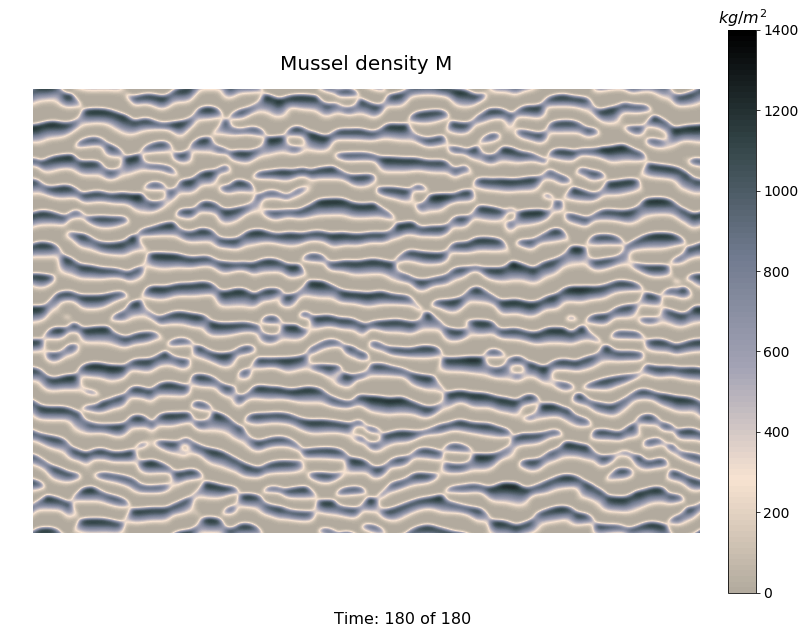

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

im = plt.imshow(M_Store[:,:,NumPlots-1], animated=True, cmap=MusselMap, clim=(0,1400),
              interpolation='bilinear')
ax.set_axis_off()
text=fig.suptitle("Time: %1.0f of %1.0f" % ((EndTime*Phi/24, EndTime*Phi/24)), x=0.47, y=0.05, fontsize=16);
ax.set_title('Mussel density M', y=1.03, fontsize=20)

f=fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
f.ax.set_title('$kg/m^2$', fontsize=16)
f.ax.tick_params(labelsize=14)

plt.tight_layout(rect=[0, 0.05, 0.94, 1])
fig.savefig('Mussels.png', dpi=120)

### Making an animation

In [20]:
from matplotlib import animation, rc

def updatefig(i): # To update the image at each iteration
    global vs
    im.set_array(M_Store[:,:,i])
    text.set_text("Time: %1.0f of %1.0f" % ((EndTime*Phi/24, EndTime*Phi/24)));
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=100, frames = NumPlots, repeat=False, blit=True)

from IPython.display import HTML
HTML(ani.to_html5_video());

In [19]:
# write to an mp4 movie
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Johan van de Koppel'), bitrate=1800)
ani.save('Mussels.mp4', writer=writer)

© Johan van de Koppel, NIOZ-Yerseke 2018